In [1]:
import numpy as np
import networkx as nx
import math
import matplotlib.pyplot as plt
import glob
import math
import csv
import pandas as pd
from __future__ import division
%matplotlib inline
import random
import itertools as it
import multiprocessing as mp

In [2]:
#read config file
#config = pd.read_csv("./wall1newThickDone.dat", names=['Index','mol','type','charge','x','y','z'], sep=' ')
config = np.loadtxt("./wall1newThickDone.dat")
overlapConfigYZ = np.loadtxt("./wall1newThickDone.dat")
overlapConfigX = np.loadtxt("./wall1newThickDone.dat")

In [3]:
#wall definitions
WallLayer = 8.0828

WallMaxX = max(config[:,4])
WallMinX = min(config[:,4])
WallMaxY = max(config[:,5])
WallMinY = min(config[:,5])
WallMaxZ = max(config[:,6])
WallMinZ = min(config[:,6])
WallErode = WallMaxX - 2*WallLayer

#simulation Box
L = 140

WallDx = WallMaxX - WallMinX
WallDy = WallMaxY - WallMinY
WallDz = WallMaxZ - WallMinZ
#Box definitions
eps = 0.02
BoxMaxX = WallMaxX + eps
BoxMinX = WallMinX - eps
BoxMaxY = WallMaxY + eps
BoxMinY = WallMinY - eps
BoxMaxZ = WallMaxZ + eps
BoxMinZ = WallMinZ - eps
BoxErode = WallErode - eps
print(BoxMaxY)

BoxDx = BoxMaxX - BoxMinX
BoxDy = BoxMaxY - BoxMinY
BoxDz = BoxMaxZ - BoxMinZ
print(BoxDx, BoxDy, BoxDz)

68.07903
24.288600000000006 137.39549 137.91813


In [4]:
#organizing atoms on list
nBoxDivisionYZ = 10
nBoxDivisionX  = 3
lenBoxCellX = BoxDx/nBoxDivisionX
lenBoxCellY = BoxDy/nBoxDivisionYZ
lenBoxCellZ = BoxDz/nBoxDivisionYZ
nCells = [nBoxDivisionX, nBoxDivisionYZ, nBoxDivisionYZ]
print(nCells)
print(lenBoxCellX, lenBoxCellY, lenBoxCellZ)

[3, 10, 10]
8.096200000000001 13.739549 13.791813


In [5]:
atomsOnRoughness = []
for j in config:
    if ((j[4] < BoxMaxX) and (BoxErode < j[4])):
        atomsOnRoughness.append(int(j[0]))
    else:
        continue
print(len(atomsOnRoughness))
print(atomsOnRoughness[:10])
print(atomsOnRoughness[-10:])        
        

22400
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[22391, 22392, 22393, 22394, 22395, 22396, 22397, 22398, 22399, 22400]


In [6]:
wallList = [[] for i in range(nBoxDivisionX*nBoxDivisionYZ**2)]
for i in config:
    x = int((i[4] + (abs(WallMinX)))/lenBoxCellX)   #Maybe I should change bottomWall to the real wall position
    y = int((i[5] + WallDy*0.5)/lenBoxCellY) 
    z = int((i[6] + WallDz*0.5)/lenBoxCellZ) 
    s = (x*nBoxDivisionYZ**2) + (y*nBoxDivisionYZ) + z
    wallList[s].append(i)

In [7]:
sum = 0
for s in range(nBoxDivisionYZ**2*nBoxDivisionX):
    sum+=(len(wallList[s]))
sum

33152

In [8]:
BoxOverlapXdis = lenBoxCellX*0.5
BoxOverlapYdis = lenBoxCellY*0.5
BoxOverlapZdis = lenBoxCellZ*0.5
print(BoxOverlapXdis, BoxOverlapYdis, BoxOverlapZdis)
BoxOverlapYinf = BoxMinY + BoxOverlapYdis
BoxOverlapZinf = BoxMinZ + BoxOverlapZdis
print(BoxOverlapYinf, BoxOverlapZinf)
BoxOverlapXinf = BoxMinX + BoxOverlapXdis
BoxOverlapXsup = BoxMaxX - BoxOverlapXdis
print(BoxOverlapXinf, BoxOverlapXsup)

4.048100000000001 6.8697745 6.8959065
-62.446685499999994 -62.42409349999999
-45.22050000000001 -29.028100000000002


In [9]:
wallListBoarderYZ = [[] for i in range(nBoxDivisionYZ**2*nBoxDivisionX)]
for i in overlapConfigYZ:
    if((i[5] < BoxOverlapYinf) or (i[6] < BoxOverlapZinf)): #boundary condition here 
        if((i[5] < BoxOverlapYinf) and (i[6] > BoxOverlapZinf)):
            y = int((i[5] + WallDy     - BoxOverlapYdis)/lenBoxCellY) # int((i[5] + BoxDy - BoxOverlapYdis)/lenBoxCellY)            
            z = int((i[6] + WallDz*0.5 - BoxOverlapZdis)/lenBoxCellZ)
            i[5] = i[5] + WallDy    
        if((i[5] > BoxOverlapYinf) and (i[6] < BoxOverlapZinf)):
            y = int((i[5] + WallDy*0.5 - BoxOverlapYdis)/lenBoxCellY) 
            z = int((i[6] + WallDz     - BoxOverlapZdis)/lenBoxCellZ)            
            i[6] = i[6] + WallDz            
        if((i[5] < BoxOverlapYinf) and (i[6] < BoxOverlapZinf)):                
            y = int((i[5] + WallDy     - BoxOverlapYdis)/lenBoxCellY)     
            z = int((i[6] + WallDz     - BoxOverlapZdis)/lenBoxCellZ)            
            i[5] = i[5] + WallDy            
            i[6] = i[6] + WallDz            
    else:  
        y = int((i[5] + WallDy*0.5 - BoxOverlapYdis)/lenBoxCellY) 
        z = int((i[6] + WallDz*0.5 - BoxOverlapZdis)/lenBoxCellZ)             

    x = int((i[4] + (abs(WallMinX)))/lenBoxCellX)    
    s = (x*nBoxDivisionYZ**2) + (y*nBoxDivisionYZ) + z
#    if (int(i[0]) in [2689, 8513, 14379, 20866, 25131, 31618]):
#        print(x,y,z,s,i[4:])                
    wallListBoarderYZ[s].append(i) 
    

In [10]:
wallListBoarderX = [[] for i in range(nBoxDivisionYZ**2*(nBoxDivisionX - 1))]
for i in overlapConfigX:
    if((i[4] > BoxOverlapXinf) and (i[4] < BoxOverlapXsup)):
        x = int((i[4] + abs(WallMinX) - BoxOverlapXdis)/lenBoxCellX)    
        y = int((i[5] + WallDy*0.5)/lenBoxCellY) 
        z = int((i[6] + WallDz*0.5)/lenBoxCellZ)     
        s = (x*nBoxDivisionYZ**2) + (y*nBoxDivisionYZ) + z
        wallListBoarderX[s].append(i)    

In [11]:
sum = 0
for s in range(nBoxDivisionYZ**2*nBoxDivisionX):
    sum+=len(wallListBoarderYZ[s])
sum

33152

In [12]:
sum = 0
for s in range(nBoxDivisionYZ**2*(nBoxDivisionX - 1)):
    sum+=len(wallListBoarderX[s])
sum

22400

In [13]:
G = nx.Graph()

In [14]:
G.add_nodes_from(config[:,0].astype(int))

In [15]:
def calcDistance(cellAtoms):
    cellEdges = []
    threshold = 1.6
    for pairAtoms in it.combinations(cellAtoms, 2):
        if (int(i[0]) in [2689, 8513, 14379, 20866, 25131, 31618]):
            print(pairAtoms[0][0], pairAtoms[1][0], np.linalg.norm(pairAtoms[0][4:] - pairAtoms[1][4:]))                
        if (np.linalg.norm(pairAtoms[0][4:] - pairAtoms[1][4:]) < threshold):
            cellEdges.append((int(pairAtoms[0][0]), int(pairAtoms[1][0])))
        else:
            continue
    return cellEdges    

In [16]:
pool = mp.Pool(processes=4)
edges1 = pool.map(calcDistance, wallList)
edges2 = pool.map(calcDistance, wallListBoarderYZ)
edges3 = pool.map(calcDistance, wallListBoarderX)
pool.close()

In [17]:
edges1 = list(it.chain.from_iterable(edges1))
edges2 = list(it.chain.from_iterable(edges2))
edges3 = list(it.chain.from_iterable(edges3))

In [18]:
G.add_edges_from(edges1)
G.add_edges_from(edges2)
G.add_edges_from(edges3)

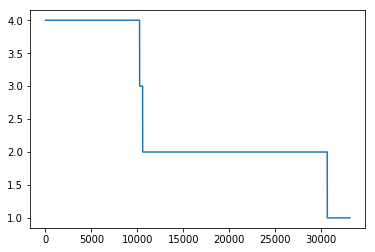

In [19]:
sequence_degree = sorted([d for n, d in G.degree], reverse=True)
aveDegree = np.mean(sequence_degree)
#plt.hist(sequence_degree, bins = 5,normed = False)
plt.plot(sequence_degree)

In [20]:
degreeDelProb = [1, 0.75, 0.5, 0.25, 0.1]
nAtomsRoughInit = len(atomsOnRoughness)

nAtomsRoughUpdate = len(atomsOnRoughness)

propTotAtomsDel = .6 #%
propAtomsDel = 0

while(propAtomsDel < propTotAtomsDel):
    tryDelAtom = int(random.uniform(0, nAtomsRoughUpdate))
    degree = G.degree(atomsOnRoughness[tryDelAtom])
    if(degreeDelProb[degree] > random.uniform(0,1)):
        G.remove_node(atomsOnRoughness[tryDelAtom])
        del atomsOnRoughness[tryDelAtom]        
        nAtomsRoughUpdate = len(atomsOnRoughness)
        propAtomsDel = (nAtomsRoughInit - nAtomsRoughUpdate)/nAtomsRoughInit
    else:
        continue
            
        
        

In [21]:
G.remove_nodes_from(list(nx.isolates(G)))

In [22]:
newG = max(nx.connected_component_subgraphs(G), key=len)

In [23]:
with open('./continuation-bridge-k00-onlywall_rough_degree.data', "w") as configRough:
    configRough.write('LAMMPS data file\n')
    configRough.write('%d atoms\n' % (len(newG.nodes())))
    configRough.write('2 bonds\n')
    configRough.write('0 angles\n')
    configRough.write('5 atom types\n')
    configRough.write('0 bond types\n')
    configRough.write('1 angle types\n')
    configRough.write('-70.0 70.0 xlo xhi\n')
    configRough.write('-70.0 70.0 ylo yhi\n')
    configRough.write('-70.0 70.0 zlo zhi\n')
    configRough.write('\n')    
    configRough.write('Masses\n\n')
    configRough.write('1 1.008\n')
    configRough.write('2 15.9994\n')
    configRough.write('3 1\n')
    configRough.write('4 1\n')
    configRough.write('5 1.008\n')
    configRough.write('\n')  
    configRough.write('Atoms\n\n')    
    newIndex = 1
    for i in newG.nodes():
        node = int(i)
        configRough.write('%d %d %d %f %f %f %f\n' % (newIndex, config[node-1][1], config[node-1][2], config[node-1][3], config[node-1][4], config[node-1][5], config[node-1][6]))
        newIndex +=1
configRough.close()       

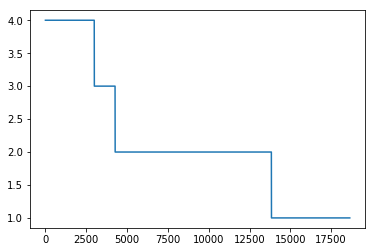

In [24]:
sequence_degree = sorted([d for n, d in G.degree], reverse=True)
aveDegree = np.mean(sequence_degree)
#plt.hist(sequence_degree, bins = 5,normed = False)
plt.plot(sequence_degree)

# Rough Sin

In [25]:
def sinRough (y, alpha, ny):
    return (BoxMaxX - alpha*(BoxMaxX - BoxErode)/2) + alpha*((BoxMaxX - BoxErode)/2)*np.sin((2*np.pi*(ny)/L)*y)
def sinSinRough (y, z, nx, ny, alpha):
    return (BoxMaxX - alpha*(BoxMaxX - BoxErode)/2) + alpha*((BoxMaxX - BoxErode)/2)*np.sin(2*np.pi*ny*y/L)*np.sin(2*np.pi*nz*z/L)

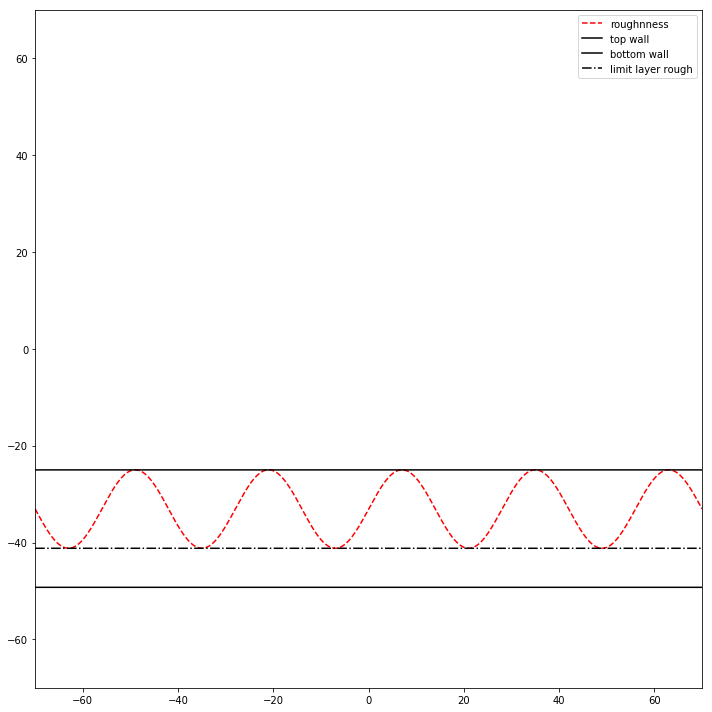

In [26]:
alpha =1
nz = ny = 5
x=np.arange(-70,70, 0.01)
y=sinRough(x, alpha, ny)
plt.figure(figsize=(10,10))
plt.plot(x, y , '--r', label = 'roughnness')
plt.plot(x, np.asarray([   WallMaxX       for i in range(len(x))]), 'k', label = 'top wall')
plt.plot(x, np.asarray([   WallMinX    for i in range(len(x))]), 'k', label = 'bottom wall')
plt.plot(x, np.asarray([BoxErode for i in range(len(x))]), 'k-.', label = 'limit layer rough')
plt.ylim(-L/2,L/2)
plt.xlim(-L/2,L/2)
plt.legend()
plt.tight_layout()

In [27]:
with open('./continuation-bridge-k00-onlywall_rough_sin.data', "w") as configRough:
    newIndex = 1
    for i in config:
        x = i[4]
        y = i[5]
        if(x <= sinRough(y, alpha, ny)):
            newIndex +=1
        else:
            continue    
    configRough.write('LAMMPS data file\n')
    configRough.write('%d atoms\n' % (newIndex - 1))
    configRough.write('2 bonds\n')
    configRough.write('0 angles\n')
    configRough.write('5 atom types\n')
    configRough.write('0 bond types\n')
    configRough.write('1 angle types\n')
    configRough.write('-70.0 70.0 xlo xhi\n')
    configRough.write('-70.0 70.0 ylo yhi\n')
    configRough.write('-70.0 70.0 zlo zhi\n')
    configRough.write('\n')    
    configRough.write('Masses\n\n')
    configRough.write('1 1.008\n')
    configRough.write('2 15.9994\n')
    configRough.write('3 1\n')
    configRough.write('4 1\n')
    configRough.write('5 1.008\n')
    configRough.write('\n')  
    configRough.write('Atoms\n\n')    
    newIndex = 1
    for i in config:
        x = i[4]
        y = i[5]
        if(x <= sinRough(y, alpha, ny)):
            configRough.write('%d %d %d %f %f %f %f\n' % (newIndex, i[1], i[2], i[3], i[4], i[5], i[6]))
            newIndex +=1
        else:
            continue
configRough.close()    



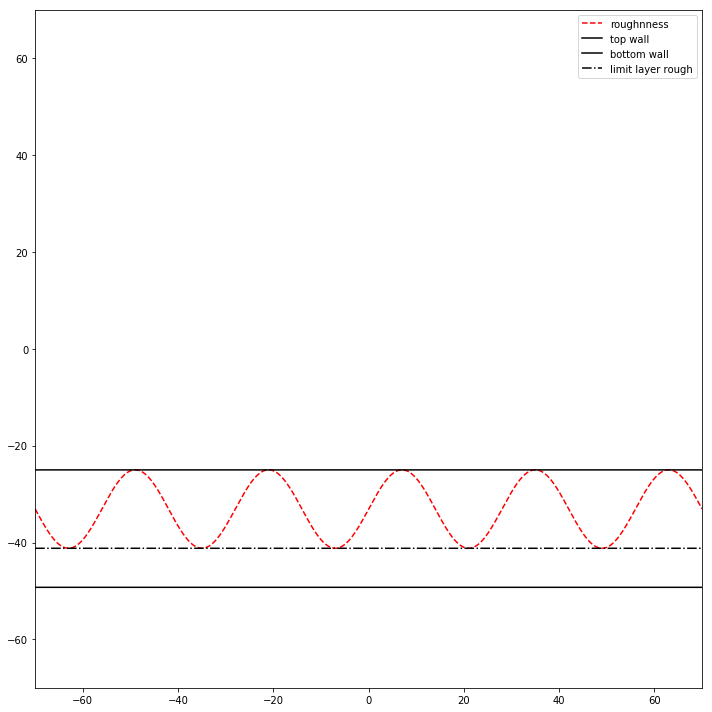

In [31]:
alpha =1
nz = ny = 5
y=np.arange(-70,70, 0.01)
x=sinSinRough(y, 35, ny, nz, alpha)
plt.figure(figsize=(10,10))
plt.plot(y, x , '--r', label = 'roughnness')
plt.plot(y, np.asarray([   WallMaxX       for i in range(len(y))]), 'k', label = 'top wall')
plt.plot(y, np.asarray([   WallMinX    for i in range(len(y))]), 'k', label = 'bottom wall')
plt.plot(y, np.asarray([BoxErode for i in range(len(y))]), 'k-.', label = 'limit layer rough')
plt.ylim(-L/2,L/2)
plt.xlim(-L/2,L/2)
plt.legend()
plt.tight_layout()

In [34]:
with open('./continuation-bridge-k00-onlywall_rough_sinsin.data', "w") as configRough:
    newIndex = 1
    for i in config:
        x = i[4]
        y = i[5]
        z = i[6]
        if(x <= sinSinRough(y, z, ny, nz, alpha)):
            newIndex +=1
        else:
            continue    
    configRough.write('LAMMPS data file\n')
    configRough.write('%d atoms\n' % (newIndex - 1))
    configRough.write('2 bonds\n')
    configRough.write('0 angles\n')
    configRough.write('5 atom types\n')
    configRough.write('0 bond types\n')
    configRough.write('1 angle types\n')
    configRough.write('-70.0 70.0 xlo xhi\n')
    configRough.write('-70.0 70.0 ylo yhi\n')
    configRough.write('-70.0 70.0 zlo zhi\n')
    configRough.write('\n')    
    configRough.write('Masses\n\n')
    configRough.write('1 1.008\n')
    configRough.write('2 15.9994\n')
    configRough.write('3 1\n')
    configRough.write('4 1\n')
    configRough.write('5 1.008\n')
    configRough.write('\n')  
    configRough.write('Atoms\n\n')    
    newIndex = 1
    for i in config:
        x = i[4]
        y = i[5]
        z = i[6]
        if(x < sinSinRough(y, z, ny, nz, alpha)):
            configRough.write('%d %d %d %f %f %f %f\n' % (newIndex, i[1], i[2], i[3], i[4], i[5], i[6]))
            newIndex +=1
        else:
            continue
configRough.close()    

